# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# Save the train and test pickle file in the same directory

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

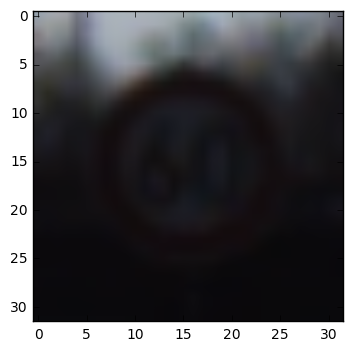

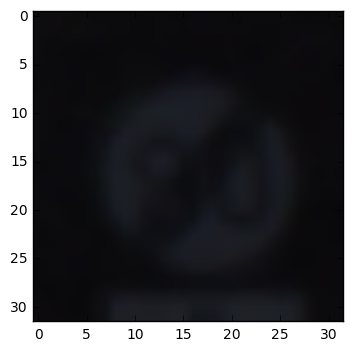

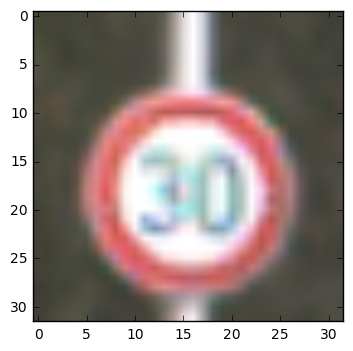

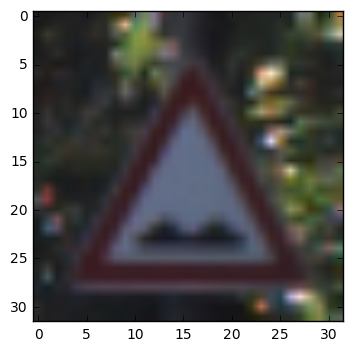

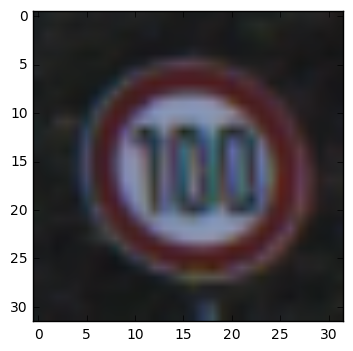

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

vis_index = np.random.choice(range(n_train), 5)
vis_images = X_train[vis_index, ...]
for img in vis_images:
    plt.figure()
    plt.imshow(img)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from random import shuffle

'''
Those are all shamelessly simplified from inception retraining example. 
Mostly for augment speed concern
'''

def distort_color(image, scope=None):
    """Distort the color of the image.
    shamelessly copied from inception retraining example

    """
    with tf.name_scope('distort_color'):

        if np.random.random() < 0.5:
            image = tf.image.random_brightness(image, max_delta=10./255)
            image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
            image = tf.image.random_hue(image, max_delta=0.2)
            image = tf.image.random_contrast(image, lower=0.5, upper=1.5)

        image = tf.clip_by_value(image, 0.0, 255.0)
    return image


def distort_image(image, scope=None):
    """Distort one image for training a network.
    Returns:
    3-D float Tensor of distorted image used for training.
    """
    with tf.name_scope('distort_image'):
        distorted_image = image
        if np.random.random() < 0.5:
            distorted_image = tf.image.random_brightness(image, max_delta=63)
            distorted_image = tf.image.random_contrast(distorted_image,
                                                 lower=0.2, upper=1.8)

            distorted_image = tf.clip_by_value(distorted_image, 0.0, 255.0)
        # Subtract off the mean and divide by the variance of the pixels.
        float_image = tf.image.per_image_standardization(distorted_image)
        return float_image

def image_preprocessing(image):

    image = distort_image(image)
    return image

    
def preprocess_batch(preprocess_op, input_tensor, batch, sess):
    
    transformed_batch = []
    
    for img in batch:            
        # run and materialize
        transformed_img = sess.run(preprocess_op, feed_dict={input_tensor: img})
        transformed_batch.append(transformed_img)   
    return np.array(transformed_batch)
    

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** Actually decided to do the pertubation on the fly. Following some pretty normal techniques such as random flip, random contrast and lighting changes. It's well known those jittering helps prevent overfit and improve generalization error. Mostly mimicking code here https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/image_retraining/retrain.py. Write two versions of transformer and used the tensorflow version in the end

In [5]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

def transformer(U, theta, out_size, name='SpatialTransformer', **kwargs):
    """Spatial Transformer Layer
    Implements a spatial transformer layer as described in [1]_.
    Based on [2]_ and edited by David Dao for Tensorflow.
    Parameters
    ----------
    U : float
        The output of a convolutional net should have the
        shape [num_batch, height, width, num_channels].
    theta: float
        The output of the
        localisation network should be [num_batch, 6].
    out_size: tuple of two ints
        The size of the output of the network (height, width)
    References
    ----------
    .. [1]  Spatial Transformer Networks
            Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu
            Submitted on 5 Jun 2015
    .. [2]  https://github.com/skaae/transformer_network/blob/master/transformerlayer.py
    Notes
    -----
    To initialize the network to the identity transform init
    ``theta`` to :
        identity = np.array([[1., 0., 0.],
                             [0., 1., 0.]])
        identity = identity.flatten()
        theta = tf.Variable(initial_value=identity)
    """

    def _repeat(x, n_repeats):
        with tf.variable_scope('_repeat'):
            rep = tf.transpose(
                tf.expand_dims(tf.ones(shape=tf.pack([n_repeats, ])), 1), [1, 0])
            rep = tf.cast(rep, 'int32')
            x = tf.matmul(tf.reshape(x, (-1, 1)), rep)
            return tf.reshape(x, [-1])

    def _interpolate(im, x, y, out_size):
        with tf.variable_scope('_interpolate'):
            # constants
            num_batch = tf.shape(im)[0]
            height = tf.shape(im)[1]
            width = tf.shape(im)[2]
            channels = tf.shape(im)[3]

            x = tf.cast(x, 'float32')
            y = tf.cast(y, 'float32')
            height_f = tf.cast(height, 'float32')
            width_f = tf.cast(width, 'float32')
            out_height = out_size[0]
            out_width = out_size[1]

            # clip coordinates to [-1, 1]
            x = tf.clip_by_value(x, -1, 1)
            y = tf.clip_by_value(y, -1, 1)

            # scale coordinates from [-1, 1] to [0, width/height-1]
            x = (x + 1) / 2 * (width_f - 1)
            y = (y + 1) / 2 * (height_f - 1)

            # do sampling
            x0_f = tf.floor(x)
            y0_f = tf.floor(y)
            x1_f = x0_f + 1
            y1_f = y0_f + 1
            x0 = tf.cast(x0_f, 'int32')
            y0 = tf.cast(y0_f, 'int32')
            x1 = tf.cast(tf.minimum(x1_f, width_f - 1), 'int32')
            y1 = tf.cast(tf.minimum(y1_f, height_f - 1), 'int32')

            dim2 = width
            dim1 = width*height
            base = _repeat(tf.range(num_batch)*dim1, out_height*out_width)
            base_y0 = base + y0*dim2
            base_y1 = base + y1*dim2
            idx_a = base_y0 + x0
            idx_b = base_y1 + x0
            idx_c = base_y0 + x1
            idx_d = base_y1 + x1

            # use indices to lookup pixels in the flat image and restore
            # channels dim
            im_flat = tf.reshape(im, tf.pack([-1, channels]))
            Ia = tf.gather(im_flat, idx_a)
            Ib = tf.gather(im_flat, idx_b)
            Ic = tf.gather(im_flat, idx_c)
            Id = tf.gather(im_flat, idx_d)

            # and finally calculate interpolated values
            wa = tf.expand_dims(((x1_f-x) * (y1_f-y)), 1)
            wb = tf.expand_dims(((x1_f-x) * (y-y0_f)), 1)
            wc = tf.expand_dims(((x-x0_f) * (y1_f-y)), 1)
            wd = tf.expand_dims(((x-x0_f) * (y-y0_f)), 1)
            output = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])
            return output

    def _meshgrid(height, width):
        with tf.variable_scope('_meshgrid'):
            # This should be equivalent to:
            #  x_t, y_t = np.meshgrid(np.linspace(-1, 1, width),
            #                         np.linspace(-1, 1, height))
            #  ones = np.ones(np.prod(x_t.shape))
            #  grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
            x_t = tf.matmul(tf.ones(shape=tf.pack([height, 1])),
                            tf.transpose(tf.expand_dims(tf.linspace(-1.0, 1.0, width), 1), [1, 0]))
            y_t = tf.matmul(tf.expand_dims(tf.linspace(-1.0, 1.0, height), 1),
                            tf.ones(shape=tf.pack([1, width])))

            x_t_flat = tf.reshape(x_t, (1, -1))
            y_t_flat = tf.reshape(y_t, (1, -1))

            ones = tf.ones_like(x_t_flat)
            grid = tf.concat(0, [x_t_flat, y_t_flat, ones])
            return grid

    def _transform(theta, input_dim, out_size):
        with tf.variable_scope('_transform'):
            num_batch = tf.shape(input_dim)[0]
            height = tf.shape(input_dim)[1]
            width = tf.shape(input_dim)[2]
            num_channels = tf.shape(input_dim)[3]
            theta = tf.reshape(theta, (-1, 2, 3))
            theta = tf.cast(theta, 'float32')

            # grid of (x_t, y_t, 1), eq (1) in ref [1]
            height_f = tf.cast(height, 'float32')
            width_f = tf.cast(width, 'float32')
            out_height = out_size[0]
            out_width = out_size[1]
            grid = _meshgrid(out_height, out_width)
            grid = tf.expand_dims(grid, 0)
            grid = tf.reshape(grid, [-1])
            grid = tf.tile(grid, tf.pack([num_batch]))
            grid = tf.reshape(grid, tf.pack([num_batch, 3, -1]))

            # Transform A x (x_t, y_t, 1)^T -> (x_s, y_s)
            T_g = tf.batch_matmul(theta, grid)
            x_s = tf.slice(T_g, [0, 0, 0], [-1, 1, -1])
            y_s = tf.slice(T_g, [0, 1, 0], [-1, 1, -1])
            x_s_flat = tf.reshape(x_s, [-1])
            y_s_flat = tf.reshape(y_s, [-1])

            input_transformed = _interpolate(
                input_dim, x_s_flat, y_s_flat,
                out_size)

            output = tf.reshape(
                input_transformed, tf.pack([num_batch, out_height, out_width, num_channels]))
            return output

    with tf.variable_scope(name):
        output = _transform(theta, U, out_size)
        return output


# some helpers


def localization_network(x, out_size=(64, 64), is_training=True):
    with tf.variable_scope('spatial_transformer_0'):

        # %% Create a fully-connected layer with 6 output nodes
        n_fc = 6
        W_fc1 = tf.Variable(tf.zeros([32*32*3, n_fc]), name='W_fc1')


        initial = np.array([[1.0, 0.01, 0.0], [0.01, 1.0, 0.0]])        
        initial = initial.astype('float32')
        initial = initial.flatten()
        
        num_batch = tf.shape(x)[0]
        W_fc_loc2 = tf.Variable(tf.zeros([6, 6]), name='W_fc_lo2')
        b_fc_loc2 = tf.Variable(initial_value=initial, name='b_fc_loc2')

        b_fc1 = tf.Variable(initial_value=initial, name='b_fc1')
        h_fc1 = tf.matmul(tf.zeros([num_batch, 32*32*3]), W_fc1) + b_fc1
        
        h_fc_loc2 = tf.nn.tanh(tf.matmul(h_fc1, W_fc_loc2) + b_fc_loc2)
        h_trans = transformer(x, h_fc_loc2, out_size)
        return h_trans

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** Reserved 20% examples on the training set for validation. As mentioned, image augmentation is online

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten

def LeNet(inputs, num_classes, is_training=True, batch_norm=False):
    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    
    # Add spatial transformer module
    inputs = localization_network(inputs, is_training=is_training)
    conv1   = tf.nn.conv2d(inputs, conv1_W, strides=[1, 2, 2, 1], padding='SAME') + conv1_b
    if batch_norm:
        conv1 = tf.contrib.layers.batch_norm(conv1, is_training=is_training, trainable=True)
    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    if batch_norm:
        conv2 = tf.contrib.layers.batch_norm(conv2, is_training=is_training, trainable=True)
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(576, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    bn_fc1 = tf.contrib.layers.batch_norm(fc1, is_training=is_training, trainable=True)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(bn_fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    bn_fc2 = tf.contrib.layers.batch_norm(fc2, is_training=is_training, trainable=True)
    bn_fc2 = tf.nn.dropout(x=bn_fc2, keep_prob=0.5)
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, num_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(num_classes))
    logits = tf.matmul(bn_fc2, fc3_W) + fc3_b
    
    return logits


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** For this pass, I only added a few batch norm layer and some dropout to facilitate training. There are a couple multi-scale network available and the spatial tranformer network which looks appealing, so I applied it. The conv2d + relu layers were replaced with the `conv2d+batch_norm+relu` as in the inception net. 

In [7]:
### Train your model here.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

EPOCHS = 60
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# training pipline
init_lr = 0.001
global_step = tf.Variable(0, trainable=False)

# decay patience 25 epoch
decay_steps = int(len(X_train) / BATCH_SIZE * 25)

print("decay steps: ", decay_steps)

lr = tf.train.exponential_decay(init_lr, global_step, decay_steps, 0.25 , staircase=True)

logits = LeNet(x, num_classes=n_classes, batch_norm=True)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = lr)
training_operation = optimizer.minimize(loss_operation, global_step=global_step)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y})
        total_loss += loss
        total_accuracy += (accuracy * len(batch_x))
    return total_loss / num_examples, total_accuracy / num_examples

# augment operation
image_augment_tensor = tf.placeholder(tf.float32, (32, 32, 3))
image_augment_op = image_preprocessing(image_augment_tensor)

decay steps:  7658


In [8]:
# start train

augment = False
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    
    num_train_examples = np.ceil(0.8 * num_examples).astype(np.int)
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        
        for offset in range(0, num_train_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            
            # augment
            batch_x = X_train[offset:end]
            if augment:
                batch_x = preprocess_batch(image_augment_op, input_tensor=image_augment_tensor, batch=batch_x, sess=sess)  
            batch_y = y_train[offset:end]
            
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        
        X_validation, y_validation = X_train[num_train_examples:], y_train[num_train_examples:]
        
        validation_loss, validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Loss = {:.g}".format(validation_loss))
        print("Validation Accuracy = {:.5g}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")
    

Training...
EPOCH 1 ...
Validation Loss = 0.005669
Validation Accuracy = 0.82604

EPOCH 2 ...
Validation Loss = 0.0028771
Validation Accuracy = 0.91519

EPOCH 3 ...
Validation Loss = 0.0019174
Validation Accuracy = 0.9421

EPOCH 4 ...
Validation Loss = 0.0013374
Validation Accuracy = 0.96059

EPOCH 5 ...
Validation Loss = 0.00098316
Validation Accuracy = 0.9736

EPOCH 6 ...
Validation Loss = 0.00084584
Validation Accuracy = 0.97539

EPOCH 7 ...
Validation Loss = 0.00067875
Validation Accuracy = 0.97998

EPOCH 8 ...
Validation Loss = 0.00055348
Validation Accuracy = 0.98278

EPOCH 9 ...
Validation Loss = 0.00044311
Validation Accuracy = 0.98852

EPOCH 10 ...
Validation Loss = 0.00046724
Validation Accuracy = 0.98342

EPOCH 11 ...
Validation Loss = 0.00039348
Validation Accuracy = 0.98827

EPOCH 12 ...
Validation Loss = 0.0003241
Validation Accuracy = 0.98814

EPOCH 13 ...
Validation Loss = 0.00029485
Validation Accuracy = 0.99184

EPOCH 14 ...
Validation Loss = 0.00028435
Validation Acc

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


In [9]:
# eval
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    _, test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.951


**Answer:** The default AdamOptimizer seems adaqute so I didn't change it at all but adding some exponential decay stuff. Tried with a few batch size and landed in 64.


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** I tried to implement some spatial transform stuff but didn't really like the image augmentation because it really looks like `fake science` to me. Eventually I landed in the spatial transform network DeepMind guys invented. Really like it as an elegant way to maintain tranformation invarience. 

And there could be some bug in my augmentation code, my best result is actually acheived without any augmentation.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [17]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import cv2

signal_mapping = [
    'Speed limit (20km/h)',
    'Speed limit (30km/h)',
    'Speed limit (50km/h)',
    'Speed limit (60km/h)',
    'Speed limit (70km/h)',
    'Speed limit (80km/h)',
    'End of speed limit (80km/h)',
    'Speed limit (100km/h)',
    'Speed limit (120km/h)',
    'No passing',
    'No passing for vehicles over 3.5 metric tons',
    'Right-of-way at the next intersection',
    'Priority road',
    'Yield',
    'Stop',
    'No vehicles',
    'Vehicles over 3.5 metric tons prohibited',
    'No entry',
    'General caution',
    'Dangerous curve to the left',
    'Dangerous curve to the right',
    'Double curve',
    'Bumpy road',
    'Slippery road',
    'Road narrows on the right',
    'Road work',
    'Traffic signals',
    'Pedestrians',
    'Children crossing',
    'Bicycles crossing',
    'Beware of ice/snow',
    'Wild animals crossing',
    'End of all speed and passing limits',
    'Turn right ahead',
    'Turn left ahead',
    'Ahead only',
    'Go straight or right',
    'Go straight or left',
    'Keep right',
    'Keep left',
    'Roundabout mandatory',
    'End of no passing',
    'End of no passing by vehicles over 3.5 metric tons',
]

label_to_signal_mapping = {i:val for i, val in enumerate(signal_mapping)}

test_images = [cv2.resize(cv2.imread(path)[:,:,::-1], (32, 32), interpolation = cv2.INTER_CUBIC) for path in glob.glob('./test_images/*.jpg')]
test_images = np.array(test_images)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** Choose some images with mixed sign and some noises(scrumbled, noisy words). 

Road narrows on the right
Beware of ice/snow
Go straight or left
General caution
No passing


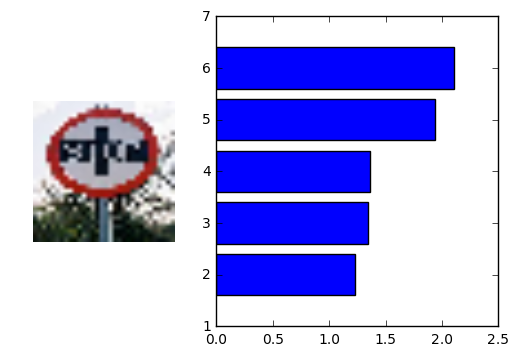

Bicycles crossing
No passing for vehicles over 3.5 metric tons
No vehicles
End of no passing by vehicles over 3.5 metric tons
Speed limit (20km/h)


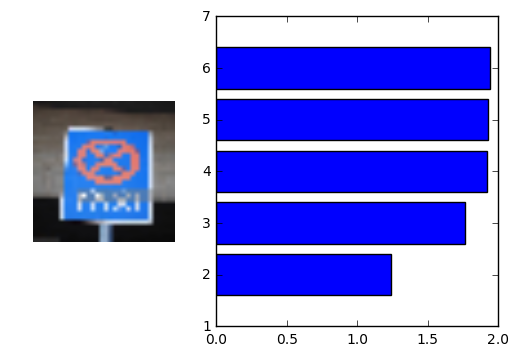

End of no passing
Traffic signals
Keep right
Pedestrians
Go straight or left


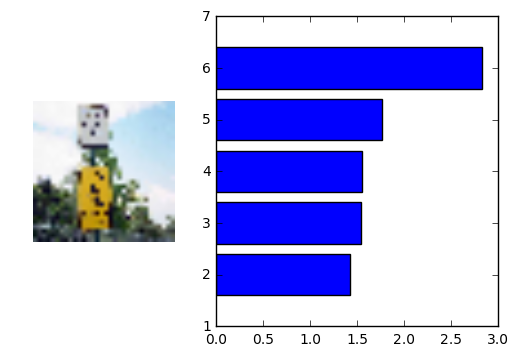

Children crossing
Road work
Right-of-way at the next intersection
Pedestrians
Keep left


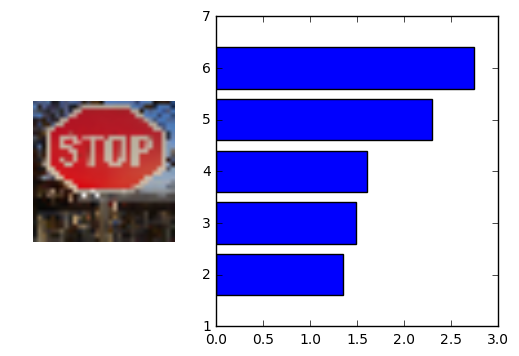

No passing for vehicles over 3.5 metric tons
Keep right
Go straight or left
Children crossing
Dangerous curve to the left


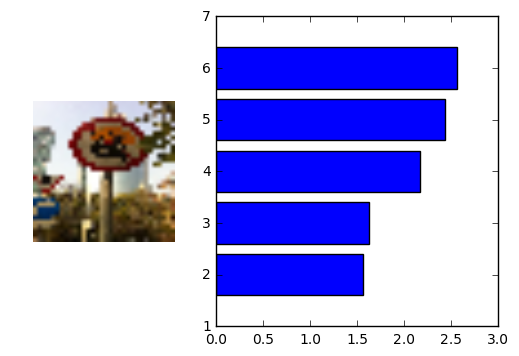

Speed limit (120km/h)
Roundabout mandatory
Speed limit (100km/h)
Dangerous curve to the left
Go straight or right


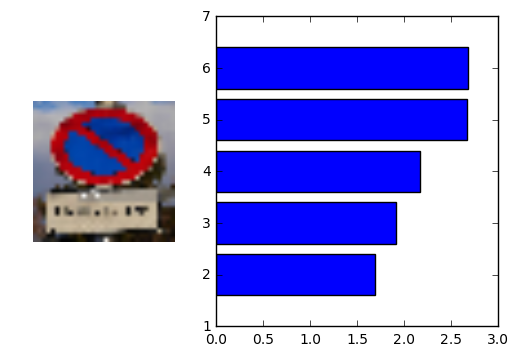

End of all speed and passing limits
Keep left
Turn left ahead
Speed limit (100km/h)
Priority road


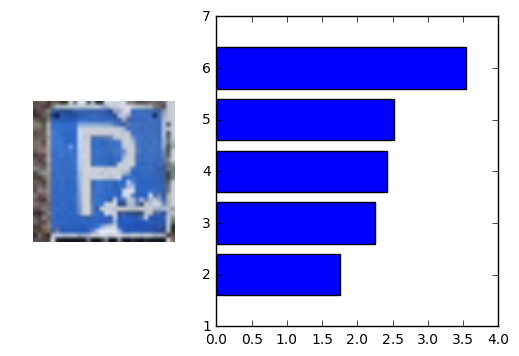

In [18]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

# Directly plotting top k here
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess.run(tf.global_variables_initializer())
    

    top5 = tf.nn.top_k(logits, 5)
    top5_predictions = sess.run(top5, feed_dict={x: test_images})

    for i, img in enumerate(test_images):
        
        plt.figure()
        
        gs = gridspec.GridSpec(1, 2, width_ratios=[1,2])
        plt.subplot(gs[0])
        plt.imshow(img)
        plt.axis('off')
        
        plt.subplot(gs[1])

        plt.barh(6-np.arange(5),top5_predictions[0][i], align='center')

        for label_ind in range(5):

            print(label_to_signal_mapping[top5_predictions[1][i][label_ind]])
        
        plt.show()
        
        


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** Those images were collected pretty randomly from internet, probably most from US. I hope more data added to the training could help (e.g. scrape from internet)

In [12]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.